# Linear regression using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model as lm, metrics, model_selection as ms

%matplotlib inline

Read in the British Crime Survey 2007-2008 dataset.

In [2]:
bcs = pd.read_csv('https://github.com/estimand/teaching-datasets/raw/master/british-crime-survey/bcs.csv')

Define predictors and response.

In [3]:
predictors = ['sex', 'age', 'marital_status', 'ethnic_origin', 'education', 'victim_last_yr']
response = 'personal_crime'
all_vars = predictors + [response]

Remove missing values.

In [4]:
bcs.dropna(subset=all_vars, inplace=True)

## Linear regression

Prepare data using `get_dummies` for categorical variables.

In [5]:
X = pd.get_dummies(bcs[predictors], drop_first=True)
y = bcs[response]

In [6]:
X.head()

,age,victim_last_yr,sex_M,marital_status_Divorced,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,ethnic_origin_Black or Black British,ethnic_origin_Chinese or Other,ethnic_origin_Mixed,ethnic_origin_White,education_Degree or Diploma,education_None,education_O Level / GCSE,education_Other
1,44.0,False,1,0,0,1,0,0,0,0,0,1,0,0,0,0
2,43.0,True,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,27.0,True,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,38.0,True,1,0,1,0,0,0,0,0,0,1,1,0,0,0
10,38.0,True,1,0,0,0,0,0,0,0,0,1,1,0,0,0


Fit the model.

In [7]:
model1 = lm.LinearRegression()
model1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
model1.intercept_

1.3488523596349857

In [9]:
model1.coef_

array([-0.00497922,  0.06318416, -0.59232379, -0.01754878,  0.04454934,
       -0.13145154,  0.00631435, -0.05417488, -0.38724638, -0.53371466,
       -0.47956965, -0.85650293, -0.13149583,  0.14547129,  0.05083886,
        0.17277346])

Alternatively, `patsy` can be used to construct the design matrices from a formula.
Dummies for categorical variables are constructed using `C` (or automatically if the variable is of type 'category').

In [10]:
from patsy import dmatrices
y, X = dmatrices('personal_crime ~ sex + age + marital_status + ethnic_origin + education + victim_last_yr', data=bcs)

Note that `dmatrices` already creates a column for the intercept, so we can set `fit_intercept` to `False` when creating our `LinearRegression` model.

In [11]:
model1 = lm.LinearRegression(fit_intercept=False)
model1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [12]:
model1.intercept_

0.0

In [13]:
model1.coef_

array([[ 1.34885236, -0.59232379, -0.01754878,  0.04454934, -0.13145154,
         0.00631435, -0.05417488, -0.38724638, -0.53371466, -0.47956965,
        -0.85650293, -0.13149583,  0.14547129,  0.05083886,  0.17277346,
         0.06318416, -0.00497922]])

## Cross-validation

Define 10 folds, and compute MSEs (one per fold).

In [14]:
ten_fold_cv = ms.KFold(n_splits=10, shuffle=True)

In [15]:
model2 = lm.LinearRegression(fit_intercept=False)
mses = ms.cross_val_score(model2, X, y, scoring='neg_mean_squared_error', cv=ten_fold_cv)

In [16]:
-mses

array([ 0.83695356,  0.88978075,  0.84821556,  0.80740212,  0.85994495,
        0.87673841,  0.92850695,  0.90250236,  0.85450527,  0.94583478])

Compute average MSE across folds.

In [17]:
np.mean(-mses)

0.87503847195906415

Compare to the MSE for the model estimated on the entire dataset.

In [18]:
metrics.mean_squared_error(y, model1.predict(X))

0.86955072330739114

## Regularisation

### $L_{1}$ penalty (LASSO)

Fit the model (by default, $\alpha$ = 1).

In [19]:
model2_lasso = lm.Lasso(fit_intercept=False).fit(X, y)

In [20]:
model2_lasso.coef_

array([ 0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.])

In [21]:
metrics.mean_squared_error(y, model2_lasso.predict(X))

1.0090202694661998

Determine 'optimal' value of $\alpha$ using grid search with cross-validation.

In [22]:
gs = ms.GridSearchCV(estimator=lm.Lasso(fit_intercept=False),
                     param_grid={'alpha': np.logspace(-10, 10, 21)},
                     scoring='neg_mean_squared_error',
                     cv=ten_fold_cv)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

'Best' MSE:

In [23]:
-gs.best_score_

0.8739086118743763

'Best' model (includes value of $\alpha$):

In [24]:
gs.best_estimator_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

All grid configurations and corresponding performances:

In [25]:
for params, mse in zip(gs.cv_results_['params'], gs.cv_results_['mean_test_score']):
    print('{:.5g}\t{:.5g}'.format(params['alpha'], -mse))

1e-10	0.87393
1e-09	0.87393
1e-08	0.87393
1e-07	0.87393
1e-06	0.87393
1e-05	0.87392
0.0001	0.87391
0.001	0.8749
0.01	0.88626
0.1	0.98067
1	1.009
10	1.009
100	1.009
1000	1.009
10000	1.009
1e+05	1.009
1e+06	1.009
1e+07	1.009
1e+08	1.009
1e+09	1.009
1e+10	1.009


Plot mean MSE across folds versus $\alpha$.

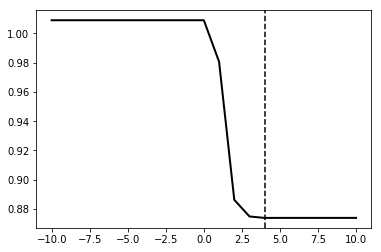

In [26]:
nlog_alphas = -np.log10(gs.param_grid['alpha'])
mean_mses = [-x for x in gs.cv_results_['mean_test_score']]
plt.figure()
plt.plot(nlog_alphas, mean_mses, linewidth=2, color='k')
plt.axvline(-np.log10(gs.best_params_['alpha']), linestyle='--', color='k')

### $L_{2}$ penalty (ridge)

Fit the model (by default, $\alpha$ = 1).

In [27]:
model2_ridge = lm.Ridge(fit_intercept=False).fit(X, y)

In [28]:
model2_ridge.coef_

array([[ 1.33247953, -0.5916182 , -0.01574667,  0.04662425, -0.12894792,
         0.00834933, -0.05249355, -0.3714977 , -0.51544254, -0.45332478,
        -0.84370674, -0.1303325 ,  0.1461262 ,  0.05185543,  0.17316842,
         0.06355789, -0.00496519]])

In [29]:
metrics.mean_squared_error(y, model2_ridge.predict(X))

0.86955793319391561

Determine 'optimal' value of $\alpha$ using grid search with cross-validation.

In [30]:
gs = ms.GridSearchCV(estimator=lm.Ridge(fit_intercept=False),
                     param_grid={'alpha': np.logspace(-10, 10, 21)},
                     scoring='neg_mean_squared_error',
                     cv=ten_fold_cv)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

'Best' MSE:

In [31]:
-gs.best_score_

0.87452730821807367

'Best' model (includes value of $\alpha$):

In [32]:
gs.best_estimator_

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

All grid configurations and corresponding performances:

In [33]:
for params, mse in zip(gs.cv_results_['params'], gs.cv_results_['mean_test_score']):
    print('{:.5g}\t{:.5g}'.format(params['alpha'], -mse))

1e-10	0.87457
1e-09	0.87457
1e-08	0.87457
1e-07	0.87457
1e-06	0.87457
1e-05	0.87457
0.0001	0.87457
0.001	0.87457
0.01	0.87457
0.1	0.87457
1	0.87453
10	0.87469
100	0.88143
1000	0.91627
10000	0.98212
1e+05	1.0058
1e+06	1.0088
1e+07	1.009
1e+08	1.009
1e+09	1.009
1e+10	1.009


Plot mean MSE across folds versus $\alpha$.

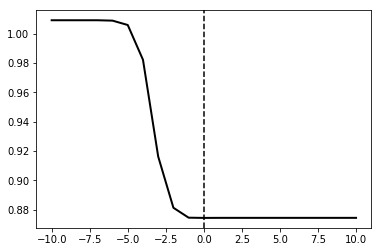

In [34]:
nlog_alphas = -np.log10(gs.param_grid['alpha'])
mean_mses = [-x for x in gs.cv_results_['mean_test_score']]
plt.figure()
plt.plot(nlog_alphas, mean_mses, linewidth=2, color='k')
plt.axvline(-np.log10(gs.best_params_['alpha']), linestyle='--', color='k')